In [1]:
import os
import pandas as pd
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

# ROC Curve Implementation
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

2025-04-23 01:36:06.838255: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-23 01:36:06.838304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-23 01:36:06.887851: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-23 01:36:06.950605: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
dataset_path = '/home/ychien13/my_github/DAT490/original_datasets'

file_paths = []
labels = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            file_path = os.path.join(root, file)
            try:
                
                with Image.open(file_path) as img:
                    img.verify()  
                file_paths.append(file_path)
                labels.append(os.path.basename(root))
            except (IOError, SyntaxError) as e:
                print(f"Invalid image file: {file_path} - {e}")

df = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

print(df['label'].value_counts())

Invalid image file: /home/ychien13/my_github/DAT490/original_datasets/normal/Tr-no_1012.jpg - cannot identify image file '/home/ychien13/my_github/DAT490/original_datasets/normal/Tr-no_1012.jpg'
Invalid image file: /home/ychien13/my_github/DAT490/original_datasets/normal/Tr-no_1011.jpg - cannot identify image file '/home/ychien13/my_github/DAT490/original_datasets/normal/Tr-no_1011.jpg'
Invalid image file: /home/ychien13/my_github/DAT490/original_datasets/normal/Tr-no_1019.jpg - cannot identify image file '/home/ychien13/my_github/DAT490/original_datasets/normal/Tr-no_1019.jpg'
label
glioma        4178
normal        4002
meningioma    3676
pituitary     3664
Name: count, dtype: int64


In [4]:
X_train, X_val, y_train, y_val = train_test_split(df['file_path'], df['label'], test_size = 0.3, random_state = 42)

train_df = pd.DataFrame({'file_path': X_train, 'label': y_train})
val_df = pd.DataFrame({'file_path': X_val, 'label': y_val})

In [23]:
img_width, img_height = 250, 250
batch_size = 32

train_datagen = ImageDataGenerator()

val_datagen = ImageDataGenerator()


train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'file_path',
    y_col = 'label',
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical' 
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'file_path',
    y_col = 'label',
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical' 
)

Found 10864 validated image filenames belonging to 4 classes.
Found 4656 validated image filenames belonging to 4 classes.


In [24]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',  
              metrics = ['accuracy'])


model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 124, 124, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 61, 61, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 29, 29, 128)      

In [25]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [26]:
early_stopping = EarlyStopping(
    monitor = 'val_loss', 
    patience = 3,        
    restore_best_weights = True   
)

batch_size = 16  
epochs = 5 

history = model.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs = epochs,
    validation_data = val_generator,
    validation_steps = len(val_generator),
    callbacks = [early_stopping] 
)

Epoch 1/5
340/340 [==============================] - 17s 48ms/step - loss: 5.8493 - accuracy: 0.6352 - val_loss: 0.7481 - val_accuracy: 0.7163
Epoch 2/5
340/340 [==============================] - 17s 49ms/step - loss: 0.6747 - accuracy: 0.7355 - val_loss: 0.5833 - val_accuracy: 0.7895
Epoch 3/5
340/340 [==============================] - 16s 48ms/step - loss: 0.5229 - accuracy: 0.8018 - val_loss: 0.4940 - val_accuracy: 0.8213
Epoch 4/5
340/340 [==============================] - 17s 50ms/step - loss: 0.3856 - accuracy: 0.8533 - val_loss: 0.3638 - val_accuracy: 0.8787
Epoch 5/5
340/340 [==============================] - 19s 56ms/step - loss: 0.3919 - accuracy: 0.8572 - val_loss: 0.4383 - val_accuracy: 0.8486


146/146 [==============================] - 4s 28ms/step - loss: 0.6368 - accuracy: 0.7655
Validation Loss: 0.636762797832489
Validation Accuracy: 0.7654638886451721


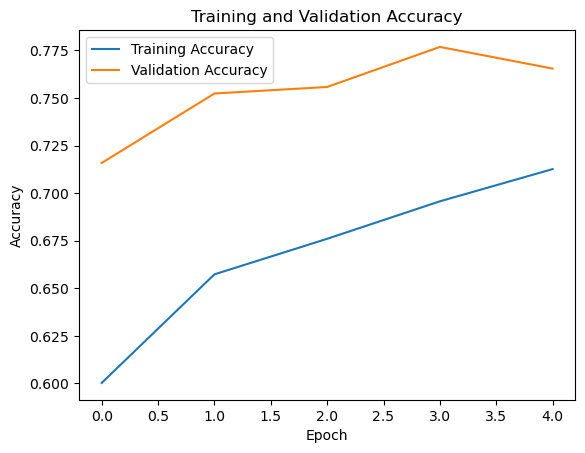

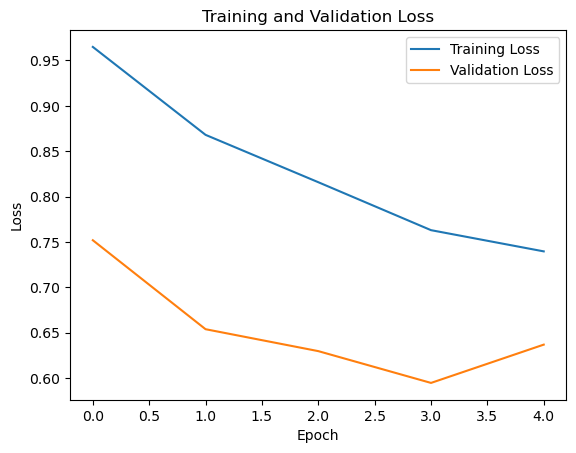

In [10]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# Reset validation generator to ensure proper ordering
val_generator.reset()

y_true = val_generator.classes
y_pred_probs = model.predict(val_generator, steps = len(val_generator))

class_names = list(val_generator.class_indices.keys())
n_classes = len(class_names)

y_true_bin = label_binarize(y_true, classes = np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

146/146 [==============================] - 4s 30ms/step


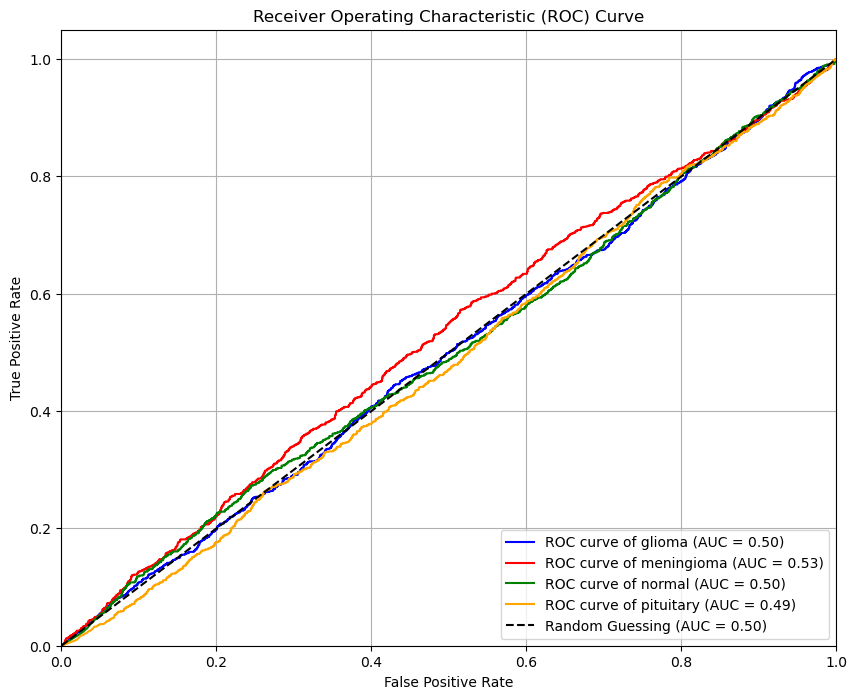

In [21]:
plt.figure(figsize = (10, 8))
colors = ['blue', 'red', 'green', 'orange']  

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color = color,
             label = 'ROC curve of {0} (AUC = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', label = 'Random Guessing (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = "lower right")
plt.grid(True)
plt.show()

In [22]:
print("\nAUC Scores:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {roc_auc[i]:.4f}")

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print(f"\nMicro-average AUC: {roc_auc['micro']:.4f}")


AUC Scores:
glioma: 0.4977
meningioma: 0.5259
normal: 0.5003
pituitary: 0.4876

Micro-average AUC: 0.5025
